# [Challenge Data - Electricity price forecasting by Elmy](https://challengedata.ens.fr/challenges/140)

## Decision Tree Classifier

Ce notebook vise à faire l'étude (mise en place, optimisation et score) de la méthode de Decision Tree Learning sur notre problème de prédiction du paramètre _spot_id_delta_. Pour cela, nous allons regrouper les données d'entrainement en deux groupes :
* _spot_id_delta_ >= 0
* _spot_id_delta_ <= 0

In [ ]:
def classifier(y: DataFrame):
    # y['spot_id_delta'] = 
    pass

In [9]:
import numpy as np
import pandas as pd
from scipy import stats

from sklearn.model_selection import train_test_split

X = pd.read_csv('../data/X_train.csv').drop('DELIVERY_START', axis=1).fillna(0)
y = pd.read_csv('../data/y_train.csv').drop('DELIVERY_START', axis=1).fillna(0)
X_rendu = pd.read_csv('../data/X_test.csv')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

y_train = y_train.loc[:, ['spot_id_delta']] # permet de ne pas déclencher un SettingWithCopyWarning
y_test = y_test.loc[:, ['spot_id_delta']]   # permet de ne pas déclencher un SettingWithCopyWarning
y_train['spot_id_delta'] = np.sign(y_train['spot_id_delta'])
y_test['spot_id_delta'] = np.sign(y_test['spot_id_delta'])

In [4]:
y_train.head()

,spot_id_delta
3933,1.0
4322,1.0
8177,1.0
3025,1.0
8326,1.0


Maintenant que les données sont classifiées, on peut entraîner un modèle de Decistion Tree Learning:

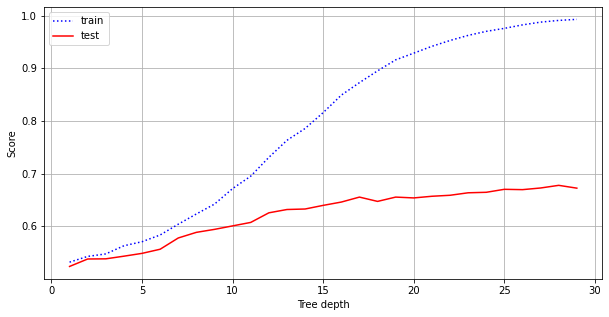

In [10]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

depths = np.arange(1, 30)
train_weights = []
test_weights = []
train_scores = []
test_scores = []

for depth in depths:
    clf = DecisionTreeClassifier(max_depth=depth)
    clf.fit(X_train, y_train)
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))
    

plt.figure(figsize=(10, 5))
plt.plot(depths, train_scores, color="b", linestyle=':', label="train")
plt.plot(depths, test_scores, color="r", linestyle='-', label="test")
plt.xlabel("Tree depth")
plt.ylabel("Score")
plt.grid()
plt.legend(loc="best")


On en déduit la profondeur optimale pour le Decision Tree Classifier :

In [11]:
best_depth = depths[np.argmax(test_scores)]
print(f"best_depth = {best_depth} for a score of {max(test_scores)}")

best_depth = 28 for a score of 0.677561282212445


Le score étant supérieur à 0.5, on peut donc prédire avec ce modèle **avec plus d'une chance sur deux** si le prix sera plus élevé sur le marché SPOT ou sur le marché Intraday.

On souhaite maintenant faire les prédictions à partir du data set X_rendu :

In [14]:
clf = DecisionTreeClassifier(max_depth=24)
clf.fit(X_train, y_train)

Y_test_submission = X_rendu[['DELIVERY_START']].copy()
Y_test_submission['spot_id_delta'] = clf.predict(X_rendu.drop('DELIVERY_START', axis=1).fillna(0))


In [15]:
Y_test_submission.head()

,DELIVERY_START,spot_id_delta
0,2023-04-02 00:00:00+02:00,1.0
1,2023-04-02 01:00:00+02:00,1.0
2,2023-04-02 02:00:00+02:00,1.0
3,2023-04-02 03:00:00+02:00,-1.0
4,2023-04-02 04:00:00+02:00,-1.0


In [16]:
Y_test_submission.to_csv('../data/y_submission.csv', index=False)

2141    2022-04-04 07:00:00+02:00
2142    2022-04-04 08:00:00+02:00
4796    2022-07-26 22:00:00+02:00
Name: DELIVERY_START, dtype: object


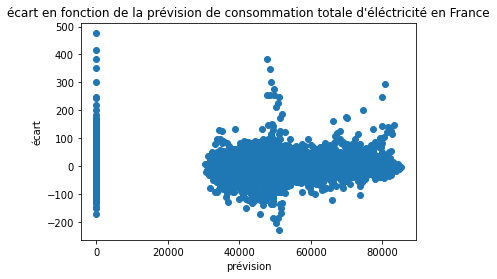

In [34]:
y_train = pd.read_csv('../data/y_train.csv').fillna(0)
X_train = pd.read_csv('../data/X_train.csv').fillna(0)

threshold = 600

eliminated = y_train[abs(y_train['spot_id_delta']) - threshold >= 0].DELIVERY_START
print(eliminated)
y_train = y_train[~y_train['DELIVERY_START'].isin(eliminated)]
X_train = X_train[~X_train['DELIVERY_START'].isin(eliminated)]


y=y_train['spot_id_delta']
x=X_train["load_forecast"]
plt.title("écart en fonction de la prévision de consommation totale d'éléctricité en France")
plt.xlabel("prévision")
plt.ylabel("écart")
plt.scatter(x,y)

In [25]:
x.size

7423

In [26]:
y.size

10605